In [6]:
import cv2
import imgaug as iaa
import numpy as np
import imgaug as ia 
import glob
import os
import segmentation_metrics as s_m
from keras.preprocessing import image
from keras import backend as K

In [2]:
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        
        else:
            lenIntersection=0
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if (np.array_equal(img[i][j],img2[i][j])):
                        lenIntersection+=1
             
            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

def iou_coef(inputs, target, smooth=255):
    intersection = (target * inputs).sum()
    union = target.sum() + inputs.sum() - intersection
    iou = np.sum(intersection) / np.sum(union)
    return iou

def iou(prediction, target):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice(pred, true, k = 255):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [3]:
def UiP(pred, true):
    #pred = cv2.imread(pred, cv2.IMREAD_COLOR)
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    (thresh, pred) = cv2.threshold(pred, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    #true = cv2.imread(true, cv2.IMREAD_COLOR)
    true = cv2.cvtColor(true, cv2.COLOR_BGR2GRAY)
    (thresh, true) = cv2.threshold(true, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    union = np.logical_or(pred, true)
    union = union.astype(np.uint8) * 255
    dif = cv2.subtract(union, true)

    return (1-cv2.countNonZero(dif) / dif.size)

def adjust_pixels(src, tolerancy):

    # convert to binary by thresholding
    ret, binary_map = cv2.threshold(src,127,255,0)

    # do connected components processing
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, None, None, None, 8, cv2.CV_32S)

    #get CC_STAT_AREA component as stats[label, COLUMN] 
    areas = stats[1:,cv2.CC_STAT_AREA]

    result = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if areas[i] >= tolerancy:   #keep
            result[labels == i + 1] = 255
            
    return result
        
def metrics_seg(pred, true):
    uip_c = UiP(pred, true)
    IoU_c = iou(pred, true)
    dice_c = dice(pred, true, k = 255)
    dice_c2 = dice_coef(pred, true)
    
    return uip_c, IoU_c, dice_c, dice_c2

In [7]:
diretorio_rgb = "../../daninhas/dataset/test/rgb/"
diretorio_true = "../../daninhas/ortomosaicos/pre-emergente/190837/marcacoes_manuais/"
diretorio_pred = "../../daninhas/ortomosaicos/pre-emergente/190837/resultados_rede_manuais/"

daninha_9216_2816.png


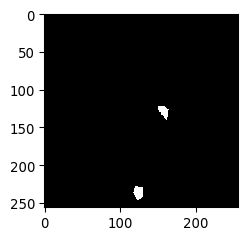

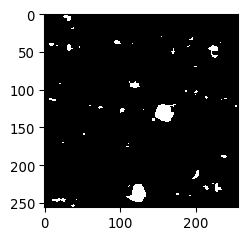

0.453125 0.19694189602446482 0.32907511497189573
daninha_13056_11264.png


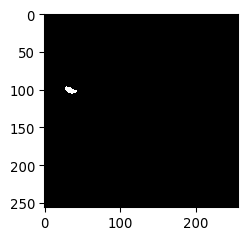

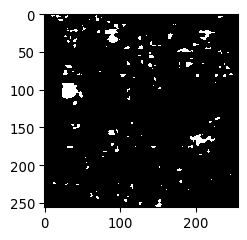

0.19140625 0.040639861651534805 0.07810552555047777
daninha_9728_13568.png


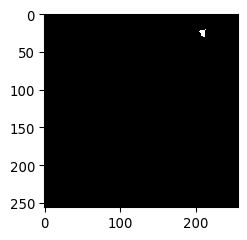

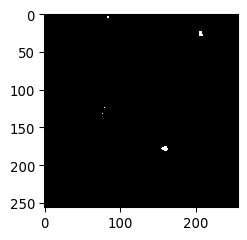

0.90625 0.11290322580645161 0.2028985507246377
iou :  0.11682832782748374 , dice : 0.20335973041567038 , acc : 0.5169270833333334 



In [8]:
from sklearn import metrics
from keras.preprocessing import image

count = 0
num_images = len(os.listdir(diretorio_pred))

c1 = 0
c2 = 0
c5 = 0

for name in os.listdir(diretorio_pred): 
    count += 1
    if count > 3:
        break
    print(name)
        
    img_true =  image.load_img(diretorio_true + name, target_size=(256,256))
    img_true = image.img_to_array(img_true)#.astype(int)
    img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)
    iaa.imshow(img_true)
    
    img_pred =  image.load_img(diretorio_pred + name, target_size=(256,256))
    img_pred = image.img_to_array(img_pred)#.astype(int)
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2GRAY)
    iaa.imshow(img_pred)

    #uip_c, IoU_c, dice_c, dice_c2 = metrics_seg(img_pred, img_true)
    
    vl_jac = metrics.jaccard_score(img_pred, img_true, average='micro') #iou
    vl_dic = dice(img_true, img_pred)
    vl_acc = metrics.accuracy_score(img_true, img_pred)
    
    c1 += vl_acc
    c2 += vl_jac
    c5 += vl_dic
        
    print(vl_acc, vl_jac, vl_dic)

print('iou : ', c2 / (count -1), ', dice :', c5 / (count -1), ', acc :', c1 / (count -1), '\n')

In [511]:
from sklearn import metrics
from keras.preprocessing import image
import imgaug as iaa

name_img = 'daninha_2304_5376'
img_t = image.load_img('../../daninhas/ortomosaicos/pre-emergente/190837/marcacoes_manuais/' + name_img + '.png', target_size=(256,256))
img_t = image.img_to_array(img_t)
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)


img_p = image.load_img('../../daninhas/ortomosaicos/pre-emergente/190837/resultados_rede_manuais/' + name_img + '.png', target_size=(256,256))
img_p = image.img_to_array(img_p)
img_p = cv2.cvtColor(img_p, cv2.COLOR_BGR2GRAY)

print('dice :', dice(img_p, img_t))
print('iou :', iou(img_p, img_t))
print('precision :', metrics.recall_score(img_p, img_t, average='micro'))

dice : 0.7684680218145761
iou : 0.6239935587761675
precision : 0.9204275534441805


In [507]:
from sklearn import metrics
from keras.preprocessing import image

diretorio_rgb = "../../daninhas/dataset/test/rgb/"
diretorio_true = "../../daninhas/ortomosaicos/pre-emergente/190837/marcacoes_manuais/"
diretorio_pred = "../../daninhas/ortomosaicos/pre-emergente/190837/resultados_rede_manuais/"

count = 0
num_images = len(os.listdir(diretorio_pred))

c1 = 0
c2 = 0
c3 = 0
c5 = 0

for name in os.listdir(diretorio_pred): 
    count += 1
    if count > 1000:
        break
    #print(name)
        
    img_true =  cv2.imread(diretorio_true + name)
    img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)
    #iaa.imshow(img_true)
    
    img_pred =  cv2.imread(diretorio_pred + name)
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2GRAY)
    #iaa.imshow(img_pred)
    img_pred = adjust_pixels(img_pred, 100)
    #iaa.imshow(img_pred)

    #uip_c, IoU_c, dice_c, dice_c2 = metrics_seg(img_pred, img_true)
    
    vl_jac = metrics.jaccard_score(img_pred, img_true, average='micro') #iou
    vl_dic = dice(img_pred, img_true)
    vl_acc = metrics.accuracy_score(img_pred, img_true)
    vl_prc = metrics.precision_score(img_pred, img_true, average='micro')
    
    c1 += vl_acc
    c2 += vl_jac
    c3 += vl_prc
    c5 += vl_dic
    
    #print(vl_acc, vl_prc, vl_jac, vl_dic)

print('iou : ', c2 / (count -1), ', dice :', c5 / (count -1),', prc : ', c3 / (count -1), ', acc :', c1 / (count -1), '\n')

iou :  0.20680179055970727 , dice : 0.309850704099268 , prc :  0.6637543768579701 , acc : 0.6720900588088088 

